In [1]:
"""
Publication Figure Generation: Scale Regime Analysis
This script evaluates a trained UNet model and generates a multi-panel figure
showing PSD and ESR analysis across different dynamical regimes.
"""

# ============================================================================
# IMPORTS AND SETUP
# ============================================================================
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import warnings
import xrft

warnings.filterwarnings('ignore')

from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet
from utils import setup_random_seeds, get_device, open_zarr, min_max_normalize

setup_random_seeds(42)
device = get_device()

# ============================================================================
# DATA LOADING
# ============================================================================
print("Loading data...")
base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

# ZCA transformation parameters
Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)

# ============================================================================
# DATA PREPARATION FOR MODEL EVALUATION
# ============================================================================
print("Preparing data for model evaluation...")

# Prepare training data for normalization statistics
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
x_train_normalized, min_vals_sst, max_vals_sst = min_max_normalize(x_train)

# Prepare test data
x_test_ssh_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_sst_original = torch.from_numpy(test.sst.values).float().unsqueeze(1).to(device)
x_test_original = torch.cat([x_test_ssh_original, x_test_sst_original], dim=1)
x_test_normalized, _, _ = min_max_normalize(x_test_original, min_vals_sst, max_vals_sst)

# Prepare test targets
y_test_physical = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)
y_test_zca = torch.from_numpy(test.zca_ubm.values).float().unsqueeze(1).to(device)
y_test = torch.cat([y_test_physical, y_test_zca], dim=1)

# Create test dataset and loader
test_dataset = TensorDataset(x_test_normalized, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ============================================================================
# MODEL LOADING AND EVALUATION
# ============================================================================
print("Loading model and generating predictions...")

# Load model
model = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4).to(device)
checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def generate_gaussian_samples(mu, log_sigma, n_samples=100):
    """Generate samples from Gaussian distribution"""
    sigma = torch.exp(log_sigma)
    samples = mu.unsqueeze(1) + sigma.unsqueeze(1) * torch.randn(
        mu.shape[0], n_samples, *mu.shape[1:], device=mu.device
    )
    return samples

# Store evaluation results
results_sst_ssh = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

# Evaluate model
with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(tqdm(test_loader, desc="Evaluating model")):
        batch_start = i * test_loader.batch_size
        batch_end = min(batch_start + test_loader.batch_size, len(test_dataset))
        current_batch_indices = list(range(batch_start, batch_end))
        
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        
        outputs = model(batch_x)
        
        ssh_batch = x_test_ssh_original[current_batch_indices]
        sst_batch = x_test_sst_original[current_batch_indices]
        
        # Ground truth
        ubm_true = batch_y_physical
        bm_true = ssh_batch - ubm_true
        
        # Predicted mean
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        bm_pred_mu = ssh_batch - ubm_pred_mu
        
        # Ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=100)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        ssh_expanded = ssh_batch.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results
        results_sst_ssh['ssh'].append(ssh_batch.cpu().numpy())
        results_sst_ssh['sst'].append(sst_batch.cpu().numpy())
        results_sst_ssh['ubm_true'].append(ubm_true.cpu().numpy())
        results_sst_ssh['bm_true'].append(bm_true.cpu().numpy())
        results_sst_ssh['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_sst_ssh['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_sst_ssh['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_sst_ssh['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

# Concatenate all results
for key in results_sst_ssh:
    results_sst_ssh[key] = np.concatenate(results_sst_ssh[key], axis=0)

print("Model evaluation complete!")

# ============================================================================
# CREATE XARRAY DATASET
# ============================================================================
print("Creating xarray dataset...")

def create_evaluation_dataset(results, stochastic_samples=100):
    """Create xarray dataset from evaluation results"""
    n_samples = results['ssh'].shape[0]
    H, W = results['ssh'].shape[2], results['ssh'].shape[3]
    
    coords = {
        'sample': range(n_samples),
        'i': range(H),
        'j': range(W),
        'stochastic_sample': range(stochastic_samples)
    }
    
    data_vars = {
        'ssh': (['sample', 'i', 'j'], results['ssh'].squeeze(1)),
        'sst': (['sample', 'i', 'j'], results['sst'].squeeze(1)),
        'ubm_truth': (['sample', 'i', 'j'], results['ubm_true'].squeeze(1)),
        'bm_truth': (['sample', 'i', 'j'], results['bm_true'].squeeze(1)),
        'ubm_pred_mean': (['sample', 'i', 'j'], results['ubm_pred_mu'].squeeze(1)),
        'bm_pred_mean': (['sample', 'i', 'j'], results['bm_pred_mu'].squeeze(1)),
        'ubm_pred_samples': (['sample', 'stochastic_sample', 'i', 'j'], 
                            results['ubm_pred_ensembles'].squeeze(2)),
        'bm_pred_samples': (['sample', 'stochastic_sample', 'i', 'j'], 
                           results['bm_pred_ensembles'].squeeze(2))
    }
    
    return xr.Dataset(data_vars, coords=coords)

# Create dataset
ds = create_evaluation_dataset(results_sst_ssh, stochastic_samples=100)

# Add km coordinates and chunk for efficiency
ds = ds.chunk(chunks={'sample': 100, 'stochastic_sample': 100})
ds = ds.assign_coords(i=ds.i * 1.5, j=ds.j * 1.5)

# ============================================================================
# SPECTRAL ANALYSIS FUNCTIONS
# ============================================================================

def isotropic_spectra(data):
    """Calculate isotropic power spectrum"""
    iso_psd = xrft.isotropic_power_spectrum(
        data, dim=['i', 'j'], detrend='constant', window=True, nfactor=2
    )
    return iso_psd

def calculate_psd_km(field, dx=1.5):
    """Calculate PSD with spatial coordinates in km"""
    i_km = np.arange(field.shape[0]) * dx
    j_km = np.arange(field.shape[1]) * dx
    da = xr.DataArray(field, dims=['i', 'j'], coords={'i': i_km, 'j': j_km})
    return isotropic_spectra(da)

def find_psd_intersection(bm_psd, ubm_psd, wavenumbers):
    """Find first intersection between BM and UBM PSDs"""
    try:
        diff = ubm_psd - bm_psd
        sign_changes = np.where(np.diff(np.sign(diff)))[0]
        
        if len(sign_changes) == 0:
            return None
        
        first_idx = sign_changes[0]
        k1, k2 = wavenumbers[first_idx], wavenumbers[first_idx + 1]
        d1, d2 = diff[first_idx], diff[first_idx + 1]
        intersection_k = k1 - d1 * (k2 - k1) / (d2 - d1)
        
        return intersection_k
    except:
        return None

def custom_bins():
    """Define custom bin edges for scale regimes"""
    return np.array([1/120, 1/40, 1/10, 1/1])

def bin_samples_by_intersection_logspace(eval_dataset, test_data, clean_idx_subset):
    """Bin samples based on BM-UBM PSD intersection wavenumbers"""
    bin_edges = custom_bins()
    n_bins = len(bin_edges) - 1
    
    bins = {f'bin_{i}': [] for i in range(n_bins)}
    no_intersection_samples = []
    intersection_wavenumbers = []
    
    print("Bin edges (spatial scale in km):")
    for i in range(n_bins):
        km_low = 1/bin_edges[i+1]
        km_high = 1/bin_edges[i]
        print(f"  Bin {i}: [{km_low:.1f}, {km_high:.1f}) km")
    
    for sample_idx in tqdm(clean_idx_subset, desc="Binning samples"):
        try:
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            
            if np.any(np.isnan(bm_true)) or np.any(np.isnan(ubm_true)):
                continue
            
            psd_bm = calculate_psd_km(bm_true)
            psd_ubm = calculate_psd_km(ubm_true)
            wavenumbers = psd_bm[list(psd_bm.coords.keys())[0]].values
            
            intersection_k = find_psd_intersection(psd_bm.values, psd_ubm.values, wavenumbers)
            
            if intersection_k is None:
                no_intersection_samples.append(sample_idx)
            else:
                intersection_wavenumbers.append(intersection_k)
                bin_idx = np.digitize(intersection_k, bin_edges) - 1
                
                if 0 <= bin_idx < n_bins:
                    bins[f'bin_{bin_idx}'].append(sample_idx)
                else:
                    no_intersection_samples.append(sample_idx)
        except:
            continue
    
    return bins, no_intersection_samples, intersection_wavenumbers, bin_edges

# ============================================================================
# SAMPLE BINNING BY SCALE REGIME
# ============================================================================
print("\nBinning samples by scale regime...")

# Filter clean samples
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx = np.where(clean_mask)[0]

# Bin samples by PSD intersection
bins, no_intersection, intersection_ks, bin_edges = bin_samples_by_intersection_logspace(
    ds, test, clean_idx
)

print(f"\nBinning results:")
for i, k in enumerate(bins.keys()):
    print(f"  {k}: {len(bins[k])} samples")
print(f"  No intersection: {len(no_intersection)} samples")


Using device: cpu
Loading data...
Preparing data for model evaluation...
Loading model and generating predictions...


Evaluating model: 100%|██████████| 29/29 [01:29<00:00,  3.08s/it]


Model evaluation complete!
Creating xarray dataset...

Binning samples by scale regime...
Bin edges (spatial scale in km):
  Bin 0: [40.0, 120.0) km
  Bin 1: [10.0, 40.0) km
  Bin 2: [1.0, 10.0) km


Binning samples: 100%|██████████| 2907/2907 [01:21<00:00, 35.47it/s]


Binning results:
  bin_0: 134 samples
  bin_1: 2445 samples
  bin_2: 275 samples
  No intersection: 53 samples



Generating publication figure...


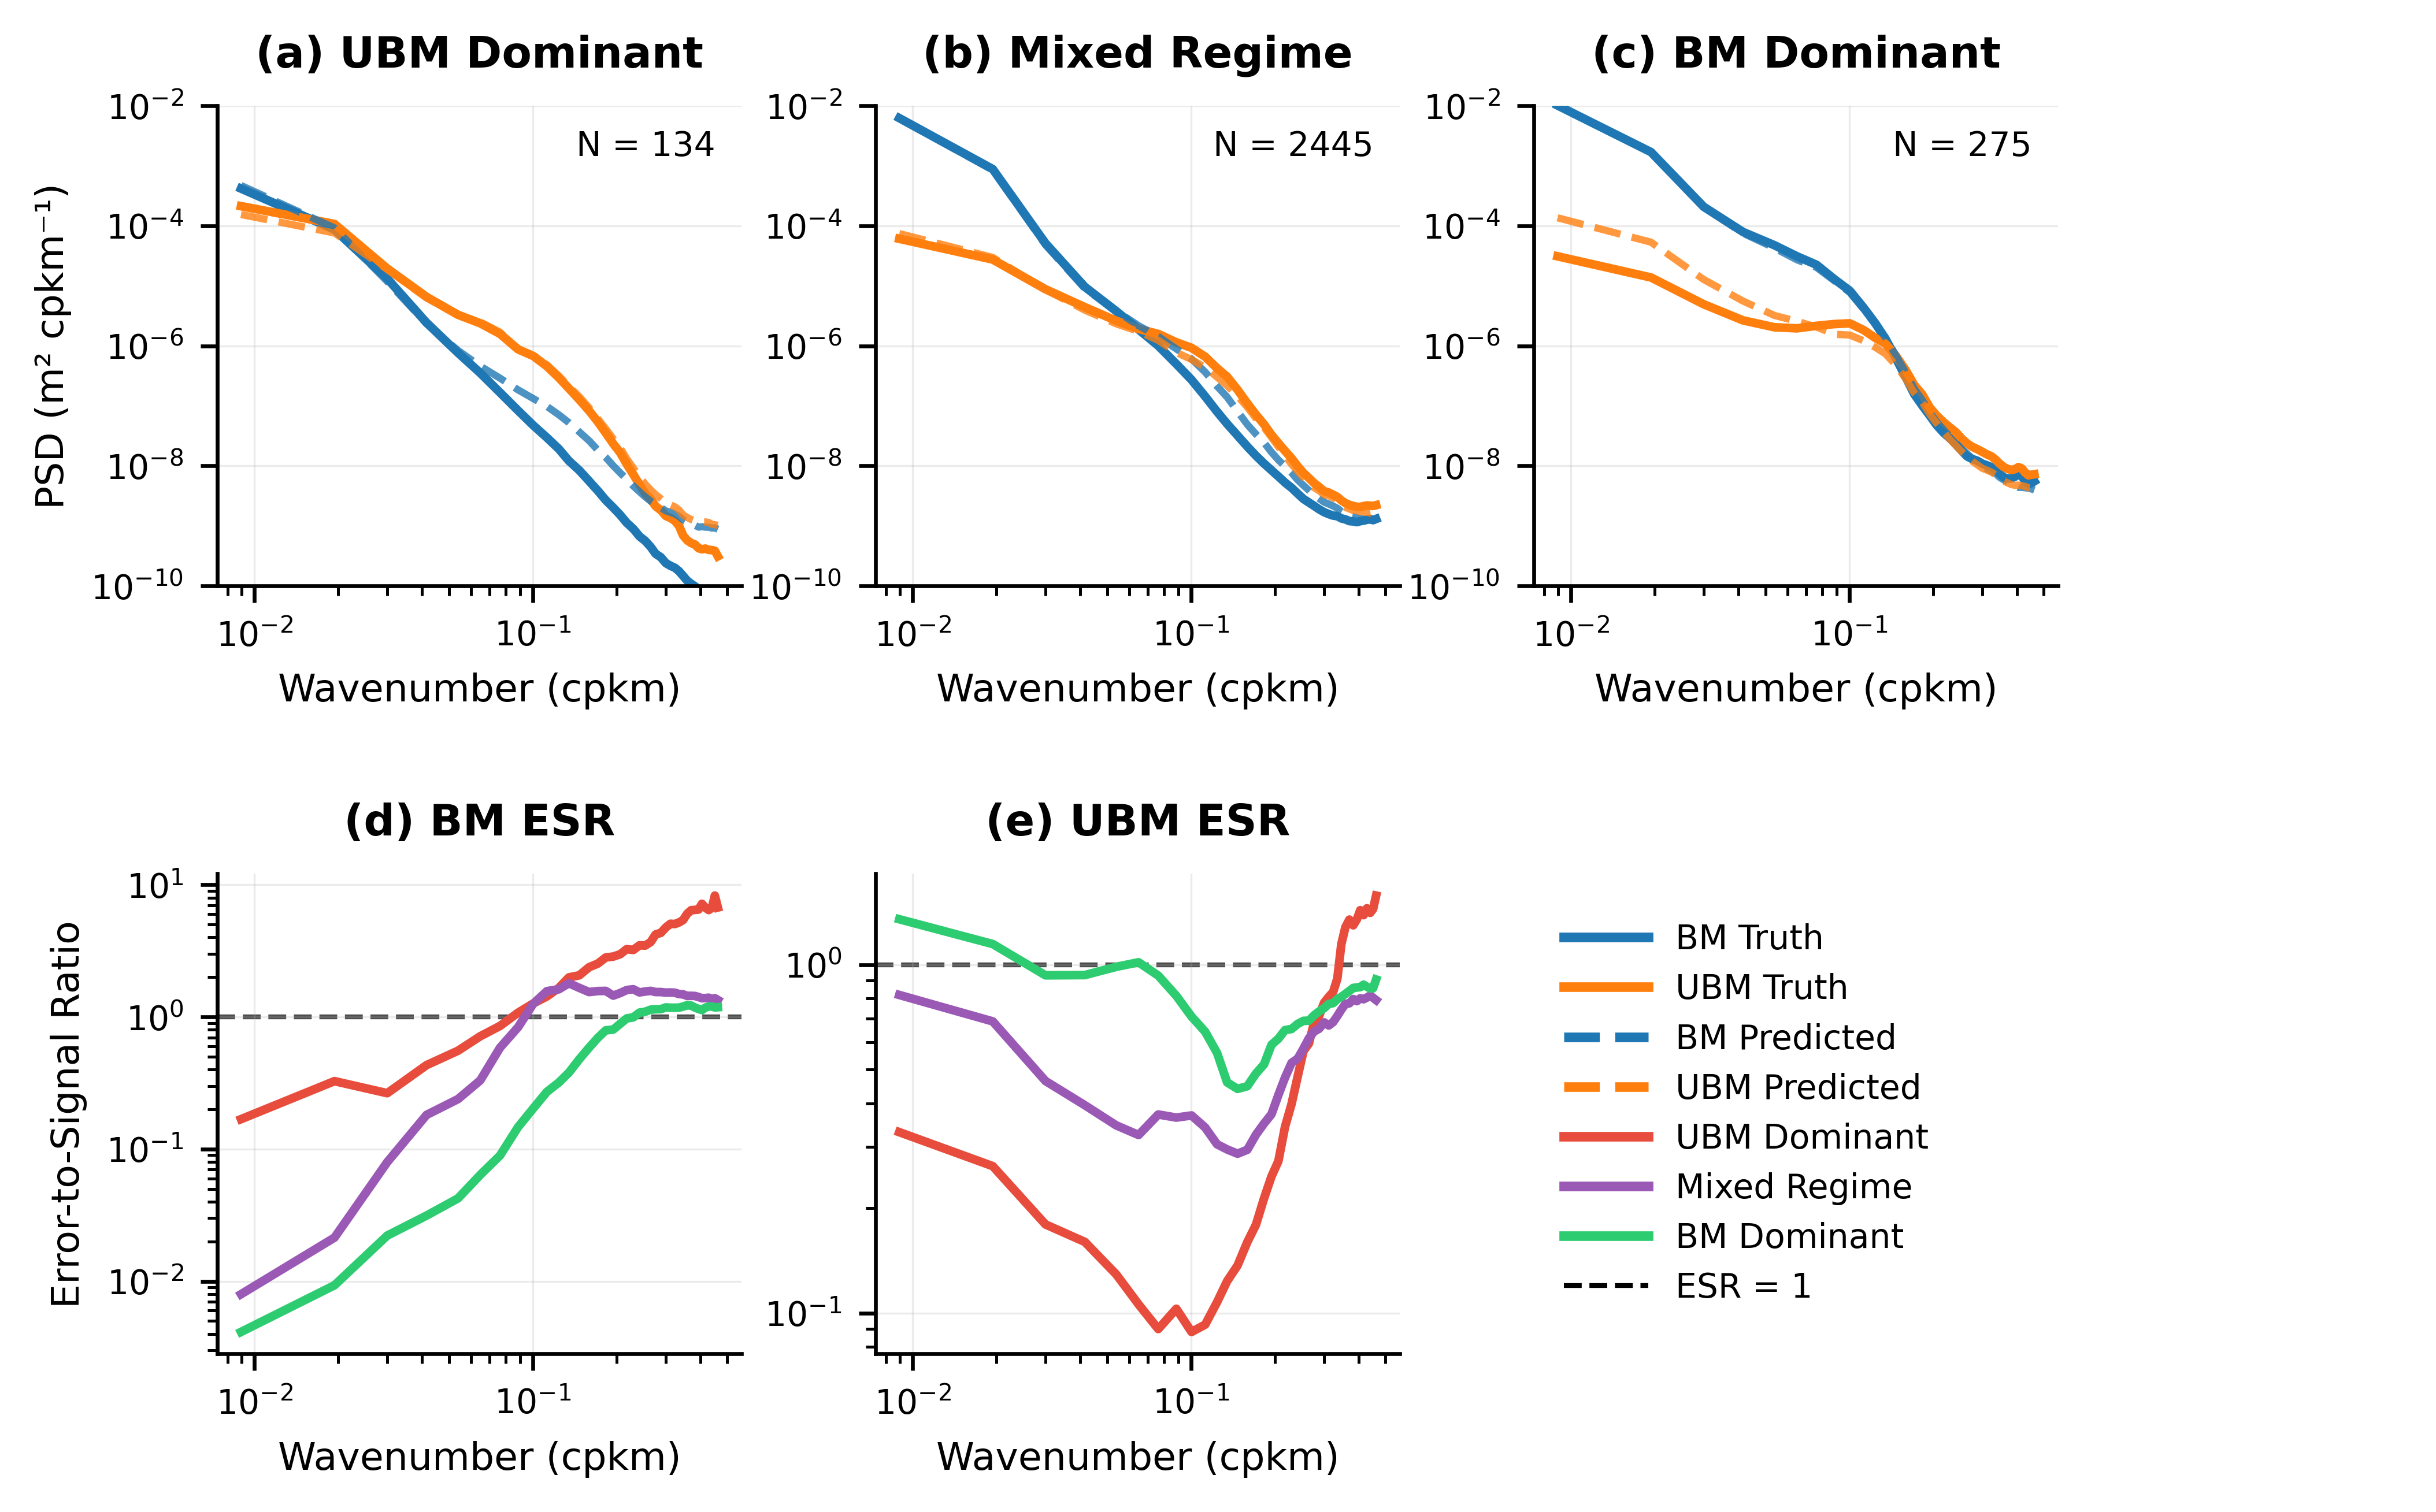

In [4]:
# Set publication-quality parameters
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 0.8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7
rcParams['legend.fontsize'] = 7
rcParams['axes.titlesize'] = 9
rcParams['figure.dpi'] = 600
rcParams['savefig.dpi'] = 600

# Color schemes
psd_colors = {
    'bm_truth': '#1f77b4',
    'ubm_truth': '#ff7f0e',
    'bm_pred': '#1f77b4',
    'ubm_pred': '#ff7f0e'
}

regime_colors = {
    0: '#e74c3c',    # Red for UBM Dominant
    1: '#9b59b6',    # Purple for Mixed Regime
    2: '#2ecc71'     # Green for BM Dominant
}

bin_labels = ['UBM Dominant', 'Mixed Regime', 'BM Dominant']

# Create figure with increased vertical spacing
fig = plt.figure(figsize=(7, 4.5))
gs = GridSpec(2, 4, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.4],
              hspace=0.60, wspace=0.3, left=0.08, right=0.98, top=0.92, bottom=0.12)

# ============================================================================
# TOP ROW: PSD Analysis by Scale Regime
# ============================================================================
esr_data = {'bm': [], 'ubm': [], 'labels': []}

for i, k in enumerate(bins.keys()):
    ax = fig.add_subplot(gs[0, i])
    samps = bins[k]
    
    # Calculate PSDs
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)
    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_samples)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_samples)
    
    # Plot truth (solid lines)
    psd_bm.mean('sample').plot(ax=ax, color=psd_colors['bm_truth'], linewidth=1.8,
                               label='BM Truth', linestyle='-')
    psd_ubm.mean('sample').plot(ax=ax, color=psd_colors['ubm_truth'], linewidth=1.8,
                                label='UBM Truth', linestyle='-')
    
    # Plot predictions (dashed lines)
    psd_bm_pred.mean(['sample', 'stochastic_sample']).plot(
        ax=ax, color=psd_colors['bm_pred'], linewidth=1.5,
        label='BM Predicted', linestyle='--', alpha=0.8
    )
    psd_ubm_pred.mean(['sample', 'stochastic_sample']).plot(
        ax=ax, color=psd_colors['ubm_pred'], linewidth=1.5,
        label='UBM Predicted', linestyle='--', alpha=0.8
    )
    
    # Set scales and limits
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-10, 1e-2])
    
    # Labels
    ax.set_xlabel('Wavenumber (cpkm)')
    ax.set_ylabel('PSD (m² cpkm⁻¹)' if i == 0 else '')
    ax.set_title(f'({chr(97+i)}) {bin_labels[i]}', fontweight='bold', pad=8)
    
    # Grid and spines
    ax.grid(True, alpha=0.25, linewidth=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    # Sample count - moved to upper right without frame
    ax.text(0.95, 0.95, f'N = {len(samps)}', transform=ax.transAxes,
            fontsize=7, verticalalignment='top', horizontalalignment='right')
    
    # Calculate ESR data for bottom row
    psd_bm_err = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean - ds.sel(sample=samps).bm_truth)
    psd_ubm_err = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean - ds.sel(sample=samps).ubm_truth)
    
    esr_bm = psd_bm_err.mean('sample') / psd_bm.mean('sample')
    esr_ubm = psd_ubm_err.mean('sample') / psd_ubm.mean('sample')
    
    esr_data['bm'].append(esr_bm)
    esr_data['ubm'].append(esr_ubm)
    esr_data['labels'].append(bin_labels[i])

# ============================================================================
# BOTTOM ROW: ESR Analysis
# ============================================================================

# Panel D: BM ESR
ax4 = fig.add_subplot(gs[1, 0])
for i in range(len(bins.keys())):
    esr_data['bm'][i].plot(ax=ax4, color=regime_colors[i], linewidth=1.8,
                           label=esr_data['labels'][i])

ax4.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7,
            label='ESR = 1', zorder=0)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Wavenumber (cpkm)')
ax4.set_ylabel('Error-to-Signal Ratio')
ax4.set_title('(d) BM ESR', fontweight='bold', pad=8)
ax4.grid(True, alpha=0.25, linewidth=0.4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_linewidth(0.8)
ax4.spines['bottom'].set_linewidth(0.8)

# Panel E: UBM ESR
ax5 = fig.add_subplot(gs[1, 1])
for i in range(len(bins.keys())):
    esr_data['ubm'][i].plot(ax=ax5, color=regime_colors[i], linewidth=1.8,
                            label=esr_data['labels'][i])

ax5.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7,
            label='ESR = 1', zorder=0)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel('Wavenumber (cpkm)')
ax5.set_ylabel('')
ax5.set_title('(e) UBM ESR', fontweight='bold', pad=8)
ax5.grid(True, alpha=0.25, linewidth=0.4)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['left'].set_linewidth(0.8)
ax5.spines['bottom'].set_linewidth(0.8)

# ============================================================================
# Combined legend in sixth panel position
# ============================================================================
legend_ax = fig.add_subplot(gs[1, 2:])
legend_ax.axis('off')

# Create combined legend elements (PSD lines + ESR regime colors)
legend_elements = []

# Add PSD legend items first
legend_elements.append(plt.Line2D([0], [0], color=psd_colors['bm_truth'], linewidth=2,
                                 linestyle='-', label='BM Truth'))
legend_elements.append(plt.Line2D([0], [0], color=psd_colors['ubm_truth'], linewidth=2,
                                 linestyle='-', label='UBM Truth'))
legend_elements.append(plt.Line2D([0], [0], color=psd_colors['bm_pred'], linewidth=2,
                                 linestyle='--', label='BM Predicted'))
legend_elements.append(plt.Line2D([0], [0], color=psd_colors['ubm_pred'], linewidth=2,
                                 linestyle='--', label='UBM Predicted'))

# Add ESR regime colors
for i in range(len(bins.keys())):
    legend_elements.append(plt.Line2D([0], [0], color=regime_colors[i], linewidth=2,
                                     label=esr_data['labels'][i]))

# Add ESR = 1 reference line
legend_elements.append(plt.Line2D([0], [0], color='black', linewidth=1,
                                 linestyle='--', label='ESR = 1'))

# Create legend without frame and increased handlelength
legend_ax.legend(handles=legend_elements, loc='center left', frameon=False,
                fontsize=7, handlelength=2.5)

# Save figure
plt.savefig('figures/publication_figure4.png', dpi=600, bbox_inches='tight',
            facecolor='white', edgecolor='none', pad_inches=0.02)

plt.show()


Generating publication figure...

Figure saved successfully!


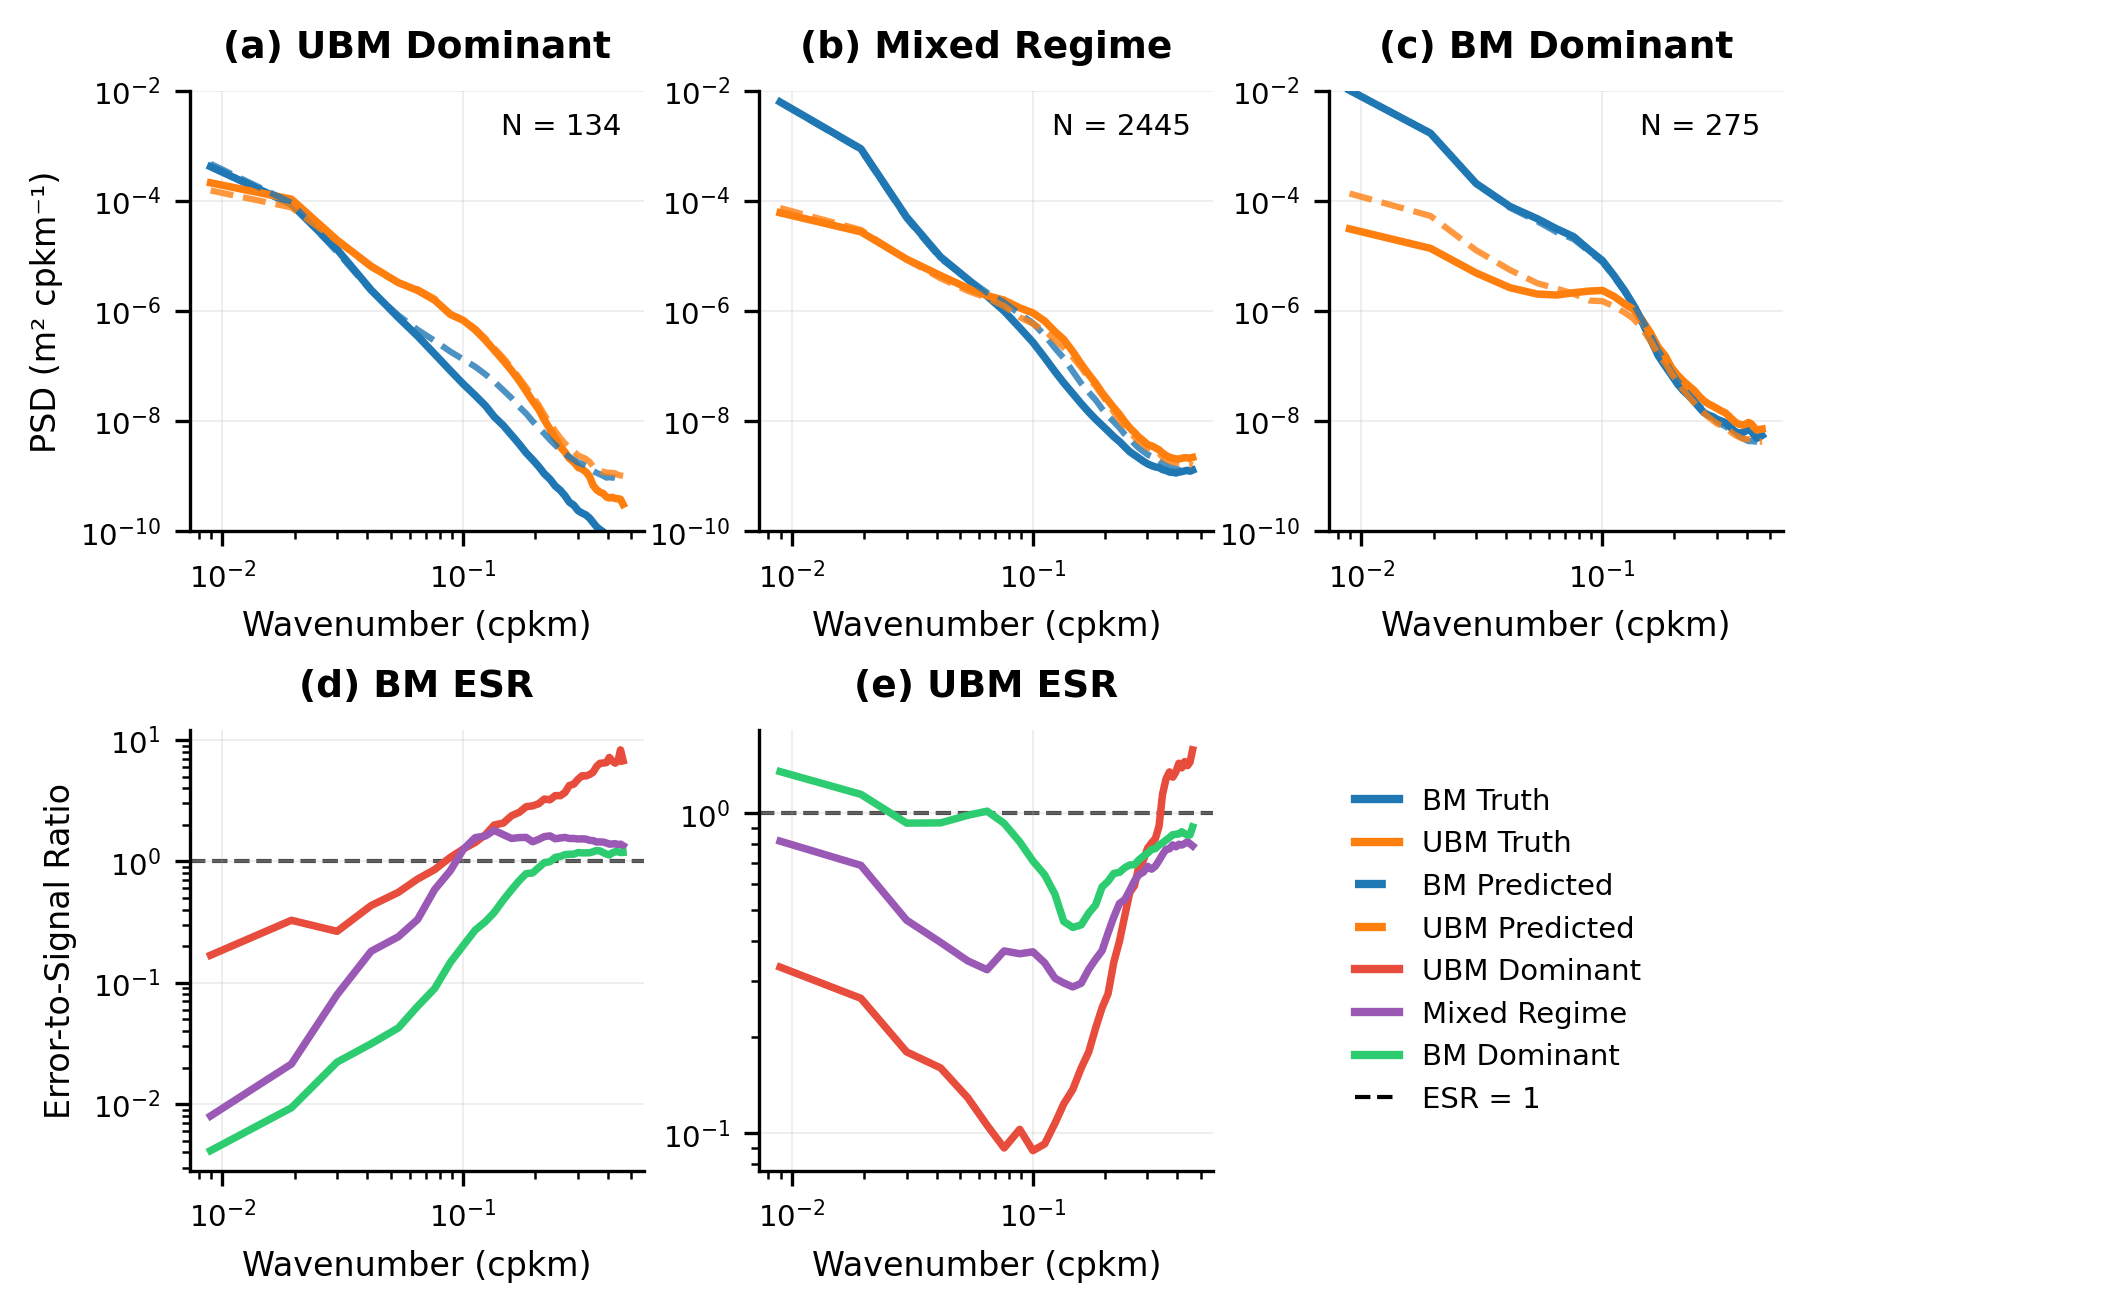

In [3]:
# Set parameters
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 0.8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7
rcParams['legend.fontsize'] = 7
rcParams['axes.titlesize'] = 9
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300

# Color schemes
psd_colors = {
    'bm_truth': '#1f77b4',
    'ubm_truth': '#ff7f0e',
    'bm_pred': '#1f77b4',
    'ubm_pred': '#ff7f0e'
}

regime_colors = {
    0: '#e74c3c',    # Red for UBM Dominant
    1: '#9b59b6',    # Purple for Mixed Regime
    2: '#2ecc71'     # Green for BM Dominant
}

bin_labels = ['UBM Dominant', 'Mixed Regime', 'BM Dominant']

# Create figure
fig = plt.figure(figsize=(7, 4.5))
gs = GridSpec(2, 4, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.4],
              hspace=0.45, wspace=0.3, left=0.08, right=0.98, top=0.92, bottom=0.12)

# ============================================================================
# TOP ROW: PSD Analysis by Scale Regime
# ============================================================================
esr_data = {'bm': [], 'ubm': [], 'labels': []}

for i, k in enumerate(bins.keys()):
    ax = fig.add_subplot(gs[0, i])
    samps = bins[k]
    
    # Calculate PSDs
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)
    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_samples)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_samples)
    
    # Plot truth (solid lines)
    psd_bm.mean('sample').plot(ax=ax, color=psd_colors['bm_truth'], linewidth=1.8,
                               label='BM Truth', linestyle='-')
    psd_ubm.mean('sample').plot(ax=ax, color=psd_colors['ubm_truth'], linewidth=1.8,
                                label='UBM Truth', linestyle='-')
    
    # Plot predictions (dashed lines)
    psd_bm_pred.mean(['sample', 'stochastic_sample']).plot(
        ax=ax, color=psd_colors['bm_pred'], linewidth=1.5,
        label='BM Predicted', linestyle='--', alpha=0.8
    )
    psd_ubm_pred.mean(['sample', 'stochastic_sample']).plot(
        ax=ax, color=psd_colors['ubm_pred'], linewidth=1.5,
        label='UBM Predicted', linestyle='--', alpha=0.8
    )
    
    # Set scales and limits
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-10, 1e-2])
    
    # Labels
    ax.set_xlabel('Wavenumber (cpkm)')
    ax.set_ylabel('PSD (m² cpkm⁻¹)' if i == 0 else '')
    ax.set_title(f'({chr(97+i)}) {bin_labels[i]}', fontweight='bold', pad=8)
    
    # Grid and spines
    ax.grid(True, alpha=0.25, linewidth=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    # Sample count - moved to upper right without frame
    ax.text(0.95, 0.95, f'N = {len(samps)}', transform=ax.transAxes,
            fontsize=7, verticalalignment='top', horizontalalignment='right')
    
    # Calculate ESR data for bottom row
    psd_bm_err = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean - ds.sel(sample=samps).bm_truth)
    psd_ubm_err = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean - ds.sel(sample=samps).ubm_truth)
    
    esr_bm = psd_bm_err.mean('sample') / psd_bm.mean('sample')
    esr_ubm = psd_ubm_err.mean('sample') / psd_ubm.mean('sample')
    
    esr_data['bm'].append(esr_bm)
    esr_data['ubm'].append(esr_ubm)
    esr_data['labels'].append(bin_labels[i])

# ============================================================================
# BOTTOM ROW: ESR Analysis
# ============================================================================

# Panel D: BM ESR
ax4 = fig.add_subplot(gs[1, 0])
for i in range(len(bins.keys())):
    esr_data['bm'][i].plot(ax=ax4, color=regime_colors[i], linewidth=1.8,
                           label=esr_data['labels'][i])

ax4.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7,
            label='ESR = 1', zorder=0)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Wavenumber (cpkm)')
ax4.set_ylabel('Error-to-Signal Ratio')
ax4.set_title('(d) BM ESR', fontweight='bold', pad=8)
ax4.grid(True, alpha=0.25, linewidth=0.4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_linewidth(0.8)
ax4.spines['bottom'].set_linewidth(0.8)

# Panel E: UBM ESR
ax5 = fig.add_subplot(gs[1, 1])
for i in range(len(bins.keys())):
    esr_data['ubm'][i].plot(ax=ax5, color=regime_colors[i], linewidth=1.8,
                            label=esr_data['labels'][i])

ax5.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7,
            label='ESR = 1', zorder=0)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel('Wavenumber (cpkm)')
ax5.set_ylabel('')
ax5.set_title('(e) UBM ESR', fontweight='bold', pad=8)
ax5.grid(True, alpha=0.25, linewidth=0.4)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['left'].set_linewidth(0.8)
ax5.spines['bottom'].set_linewidth(0.8)

# ============================================================================
# Combined legend in sixth panel position
# ============================================================================
legend_ax = fig.add_subplot(gs[1, 2:])
legend_ax.axis('off')

# Create combined legend elements (PSD lines + ESR regime colors)
legend_elements = []

# Add PSD legend items first
legend_elements.append(plt.Line2D([0], [0], color=psd_colors['bm_truth'], linewidth=2,
                                 linestyle='-', label='BM Truth'))
legend_elements.append(plt.Line2D([0], [0], color=psd_colors['ubm_truth'], linewidth=2,
                                 linestyle='-', label='UBM Truth'))
legend_elements.append(plt.Line2D([0], [0], color=psd_colors['bm_pred'], linewidth=2,
                                 linestyle='--', label='BM Predicted'))
legend_elements.append(plt.Line2D([0], [0], color=psd_colors['ubm_pred'], linewidth=2,
                                 linestyle='--', label='UBM Predicted'))

# Add ESR regime colors
for i in range(len(bins.keys())):
    legend_elements.append(plt.Line2D([0], [0], color=regime_colors[i], linewidth=2,
                                     label=esr_data['labels'][i]))

# Add ESR = 1 reference line
legend_elements.append(plt.Line2D([0], [0], color='black', linewidth=1,
                                 linestyle='--', label='ESR = 1'))

# Create legend without frame
legend_ax.legend(handles=legend_elements, loc='center left', frameon=False,
                fontsize=7, handlelength=1.5)

# Save figure
plt.savefig('figures/publication_figure4.png', dpi=600, bbox_inches='tight',
            facecolor='white', edgecolor='none', pad_inches=0.02)

plt.show()